In [2]:
# import library
import sys

from sklearn import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imutils import paths
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# initialize the initial learning rate, number of epochs to train and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [4]:
# Cek dataset
DIRECTORY = "./dataset"
if not os.path.isdir(DIRECTORY):
	print("data directory does not exist")
	sys.exit(0)
else:
	print("Reading dataset...")
CATEGORIES = os.listdir(DIRECTORY)

Reading dataset...


PREVIEW DISTRIBUSI DATA

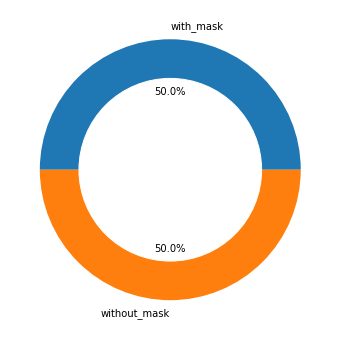

Dataset details:
[{'without_mask': 686}, {'with_mask': 690}, {'total': 1376}]


In [5]:
def get_datset_details():
    result = []

    for CATEGORIE in CATEGORIES:
        count = len(os.listdir(DIRECTORY + "/" + CATEGORIE))
        result.append({CATEGORIE : count})
    
    total = sum(result[i][CATEGORIES[i]] for i in range(len(CATEGORIES)))
    result.append({'total': total})

    return result

unique = np.unique(CATEGORIES)
label_distr = {i: CATEGORIES.count(i) for i in CATEGORIES}.values()

plt.figure(figsize=(12, 6))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(label_distr, labels=unique, autopct='%1.1f%%')
plt.gcf().gca().add_artist(my_circle)
plt.show()


print("Dataset details:")
print(get_datset_details())



In [6]:
# baca dataset
print("loading images...")

data = []
labels = []

# complete folder of dataset is enter into data and labels(it has category) list
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        print("processing image: {}".format(img_path))

        data.append(image)
        labels.append(category)


loading images...
processing image: ./dataset\without_mask\0.jpg
processing image: ./dataset\without_mask\1.jpg
processing image: ./dataset\without_mask\10.jpg
processing image: ./dataset\without_mask\100.jpg
processing image: ./dataset\without_mask\101.jpg
processing image: ./dataset\without_mask\102.jpg
processing image: ./dataset\without_mask\104.jpg
processing image: ./dataset\without_mask\105.jpg
processing image: ./dataset\without_mask\106.jpg
processing image: ./dataset\without_mask\107.jpg
processing image: ./dataset\without_mask\108.jpg
processing image: ./dataset\without_mask\109.jpg
processing image: ./dataset\without_mask\11.jpg
processing image: ./dataset\without_mask\110.jpg
processing image: ./dataset\without_mask\111.jpg
processing image: ./dataset\without_mask\112.jpg
processing image: ./dataset\without_mask\114.jpg
processing image: ./dataset\without_mask\115.jpg
processing image: ./dataset\without_mask\116.jpg
processing image: ./dataset\without_mask\117.jpg
processi

Pembuatan class berdasarkan data yang ada

In [7]:
# perform one-hot encoding on the labels
# As category having 2 fields with mask, without mask we need to convert them into number(0 and 1) so called LabelBinarizer()
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# converting both data and labels list to array
data = np.array(data, dtype="float32")
labels = np.array(labels)

print("Classes: {}".format(lb.classes_))

Classes: ['with_mask' 'without_mask']


Split data menjadi training dan testing

In [8]:
# splitting into train and test data
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

print("Test data shape: {}".format(testX.shape))
print("Train data shape: {}".format(trainX.shape))

Test data shape: (276, 224, 224, 3)
Train data shape: (1100, 224, 224, 3)


In [9]:

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

CREATE CNN MODEL

In [11]:

baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel) 
headModel = Dense(len(lb.classes_), activation="softmax")(headModel) 

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

model.summary()

compiling model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                          

Train CNN Model

In [298]:
# train the head of the network
print("Training model...")
hist = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Training model...
Epoch 1/20
34/34 [==============================] - 49s 1s/step - loss: 0.4807 - accuracy: 0.8127 - val_loss: 0.2032 - val_accuracy: 0.9891
Epoch 2/20
34/34 [==============================] - 31s 918ms/step - loss: 0.1970 - accuracy: 0.9682 - val_loss: 0.0988 - val_accuracy: 0.9928
Epoch 3/20
34/34 [==============================] - 32s 929ms/step - loss: 0.1032 - accuracy: 0.9906 - val_loss: 0.0673 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 32s 941ms/step - loss: 0.0797 - accuracy: 0.9906 - val_loss: 0.0483 - val_accuracy: 0.9928
Epoch 5/20
34/34 [==============================] - 31s 905ms/step - loss: 0.0620 - accuracy: 0.9888 - val_loss: 0.0397 - val_accuracy: 0.9928
Epoch 6/20
34/34 [==============================] - 32s 938ms/step - loss: 0.0427 - accuracy: 0.9963 - val_loss: 0.0343 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 37s 1s/step - loss: 0.0381 - accuracy: 0.9963 - val_loss: 0.0294 - val_accu

TEST MODEL

processing image: ./test_image/AdeIndra.jpeg
[[8.937956e-04 9.991062e-01]]
without_mask


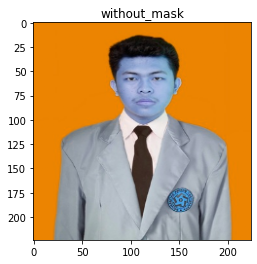

processing image: ./test_image/betha.jpg
[[0.9970204  0.00297957]]
with_mask


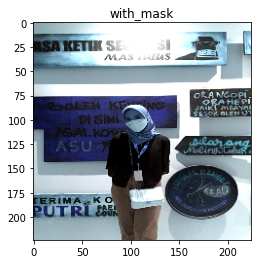

processing image: ./test_image/halim.jpg
[[0.9952832  0.00471679]]
with_mask


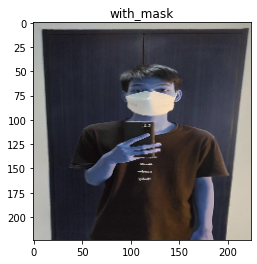

processing image: ./test_image/okta.jpg
[[0.3760387  0.62396127]]
without_mask


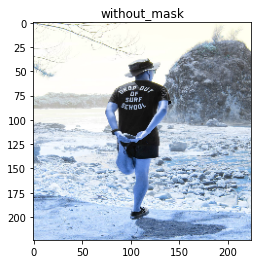

processing image: ./test_image/WibiSini.jpg
[[0.04899999 0.951     ]]
without_mask


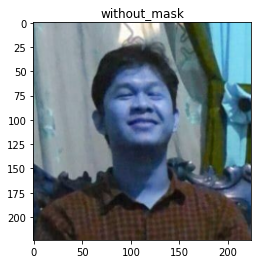

In [299]:
import cv2

images_test = './test_image/'

for image_test in os.listdir(images_test):
    #test model and show result image
    img_path = os.path.join(images_test, image_test)
    print("processing image: {}".format(img_path))
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img.astype("float32")
    img = img / 255.0
    img = img.reshape(1, 224, 224, 3)
    preds = model.predict(img)
    print(preds)
    print(lb.classes_[np.argmax(preds)])

    # plot image and prediction result
    plt.imshow(img[0])
    plt.title(lb.classes_[np.argmax(preds)])
    plt.show()







EVALUASI


In [306]:
print("evaluating after training model...")
predIdxs = model.predict(testX, batch_size=BS)

print("predIdxs: {}".format(predIdxs))

evaluating after training model...
predIdxs: [[7.26153672e-01 2.73846328e-01]
 [1.00000000e+00 1.56758539e-09]
 [1.09771520e-06 9.99998927e-01]
 [9.99999881e-01 1.74115797e-07]
 [1.54685995e-06 9.99998450e-01]
 [1.08407414e-06 9.99998927e-01]
 [1.00000000e+00 1.16791457e-08]
 [1.35321679e-05 9.99986410e-01]
 [9.96293128e-01 3.70688853e-03]
 [3.66968465e-08 1.00000000e+00]
 [4.68677053e-09 1.00000000e+00]
 [7.44141246e-08 9.99999881e-01]
 [9.99999762e-01 1.82840353e-07]
 [1.00000000e+00 7.55495458e-11]
 [2.10627800e-08 1.00000000e+00]
 [2.22390645e-06 9.99997735e-01]
 [1.00000000e+00 2.23959851e-09]
 [1.72588074e-07 9.99999881e-01]
 [1.00000000e+00 1.09102050e-09]
 [1.80629556e-07 9.99999762e-01]
 [1.00000000e+00 3.98222566e-09]
 [2.06190176e-08 1.00000000e+00]
 [1.00000000e+00 1.49117649e-10]
 [1.00000000e+00 1.08819673e-08]
 [1.00000000e+00 1.86213356e-08]
 [4.30122873e-06 9.99995708e-01]
 [1.00000000e+00 1.19612871e-08]
 [9.98590171e-01 1.40985497e-03]
 [6.40044618e-07 9.99999404e-01

In [307]:
# cek evaluasi rmse
rmse = np.sqrt(metrics.mean_squared_error(np.array(testY), predIdxs))
print("RMSE: ", rmse)

RMSE:  0.030189527


In [308]:
# cek evaluasi accuracy
acc = accuracy_score(testY.argmax(axis=1), np.argmax(predIdxs, axis=1))
print ("ACCURACY: ", acc)

ACCURACY:  1.0


In [309]:
# cek evaluasi classification report
print(classification_report(testY.argmax(axis=1), np.argmax(predIdxs, axis=1),
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       138
without_mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



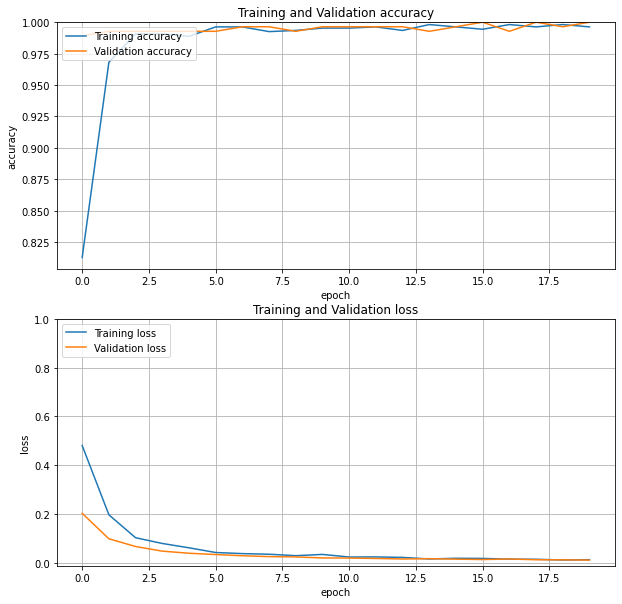

In [310]:
# tampilkan grafik loss dan accuracy
train = [
    ['accuracy', 'val_accuracy'],
    ['loss', 'val_loss']
]

plt.figure(figsize=(10, 10))

for i in range(len(train)):
    plt.subplot(2, 1, i+1)
    plt.title('Training and Validation ' + train[i][0])
    plt.plot(hist.history[train[i][0]], label='Training ' + train[i][0])
    plt.plot(hist.history[train[i][1]], label='Validation ' + train[i][0])
    plt.legend(loc='upper left')
    plt.ylabel(train[i][0])
    plt.xlabel('epoch')
    plt.grid(True)
    plt.ylim([min(plt.ylim()),1])

plt.show()


SIMPAN MODEL KE LOCAL

In [311]:
print("saving mask detector model...")
if not os.path.isdir("model"):
    os.mkdir("model")

SAVE_PATH = "./model/mask_detector.h5"

model.save(SAVE_PATH, save_format="h5")

print("model saved to " + SAVE_PATH)

saving mask detector model...
model saved to ./model/mask_detector.h5
